In [6]:
import numpy as np
import yfinance as yf

<h2>Getting stock data</h2>

In [7]:
def make_stock_df(symbol):
    tickerData = yf.Ticker(symbol)
    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    dow = tickerDf.index.day_of_week
    data = tickerDf[["Close", "Volume"]]
    data.insert(1, 'Date_Week', dow)
    return data

In [8]:
def get_yahoo_stock_data(symbol, columns=None, dfrom='2020-1-1'):
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    tickerDf["Date_Week"] = tickerDf.index.day_of_week
    targetDf = tickerDf if columns is None else tickerDf[columns]
    return targetDf

In [9]:
# ["Date_Week", "Open", "High", "Low", "Close", "Volume"]
TSM_df = get_yahoo_stock_data("TSM", columns=None, dfrom='2010-1-1')
TSM_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date_Week
Date,,,,,,,,
2010-01-04 00:00:00-05:00,7.586668,7.718725,7.573463,7.646094,8096400,0.0,0,0
2010-01-05 00:00:00-05:00,7.659303,7.698919,7.566863,7.613082,14375900,0.0,0,1
2010-01-06 00:00:00-05:00,7.632890,7.665904,7.514038,7.586669,13608400,0.0,0,2
2010-01-07 00:00:00-05:00,7.533847,7.553655,7.309350,7.335761,27346600,0.0,0,3
2010-01-08 00:00:00-05:00,7.355571,7.408394,7.282939,7.329160,16895300,0.0,0,4
...,...,...,...,...,...,...,...,...
2022-09-29 00:00:00-04:00,70.519997,70.680000,68.480003,69.279999,16120300,0.0,0,3
2022-09-30 00:00:00-04:00,67.809998,69.650002,67.739998,68.559998,10463200,0.0,0,4
2022-10-03 00:00:00-04:00,68.080002,69.570000,67.650002,69.250000,11945100,0.0,0,0


<AxesSubplot:xlabel='Date'>

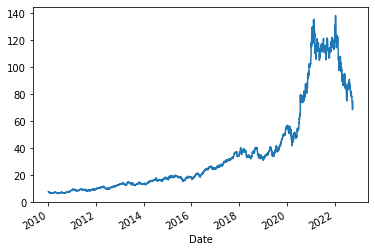

In [10]:
TSM_df.Close.plot()

<H2>Use dummy rules as price prediction</H2>

In [11]:
def _gen_another_word_price_rule(yesterday_close, yesterday_volume, bf_yesterday_close, bf_yesterday_volume, today_volume, date_week):
    price_change = yesterday_close - bf_yesterday_close
    volume_change = yesterday_volume - bf_yesterday_volume
    sign = 1.0 if price_change * volume_change > 0 else -1.0

    gen_noise = today_volume > np.max(
        [yesterday_volume, bf_yesterday_volume]
    )
    if gen_noise and date_week == 4:
        sign = -1.0
    elif gen_noise and date_week == 0:
        sign = 1.0
    price_base = abs(price_change)
    price_factor = np.mean([today_volume / yesterday_volume, today_volume / bf_yesterday_volume])
    if abs(price_base * price_factor) < yesterday_close * 0.10:
        today_price = yesterday_close + sign * price_base * price_factor
    else:
        today_price = yesterday_close + sign * yesterday_close * 0.10 
    return today_price

In [12]:
def _gen_another_word_price(kl_another_word):
    for ind in np.arange(2, kl_another_word.shape[0]):
        bf_yesterday = kl_another_word.iloc[ind - 2]
        yesterday = kl_another_word.iloc[ind - 1]
        today = kl_another_word.iloc[ind]

        kl_another_word.Close[ind] = _gen_another_word_price_rule(yesterday.Close, yesterday.Volume, bf_yesterday.Close, bf_yesterday.Volume, today.Volume, today.Date_Week)

In [13]:
def change_real_to_another_word(symbol):
    #kl_pd = ABuSymbolPd.make_kl_df(symbol)
    #if kl_pd is not None:
    #    kl_fairy_tale = kl_pd.filter(['Close', 'Date_Week', 'Volume'])
    #    kl_fairy_tale['close'][2:] = np.nan
    #    _gen_another_word_price(kl_fairy_tale)
    #    return kl_fairy_tale

    # get data on this ticker (FROM YAHOO INSTEAD)
    data = make_stock_df(symbol)
    if data is not None:
        data['Close'][2:] = np.nan
        _gen_another_word_price(data)
        return data

In [14]:
choice_symbols = ['AAPL', 'GOOG', 'TSLA']
another_word_dict = {} 
real_dict = {}
for symbol in choice_symbols:
    another_word_dict[symbol] = change_real_to_another_word(symbol)
    real_dict[symbol] = make_stock_df(symbol)

another_word_dict['TSLA'].head()

/var/folders/lr/5937yqy57yjgyy5kt7ch_ptw0000gp/T/ipykernel_87676/1106292543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_another_word.Close[ind] = _gen_another_word_price_rule(yesterday.Close, yesterday.Volume, bf_yesterday.Close, bf_yesterday.Volume, today.Volume, today.Date_Week)
/var/folders/lr/5937yqy57yjgyy5kt7ch_ptw0000gp/T/ipykernel_87676/1106292543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kl_another_word.Close[ind] = _gen_another_word_price_rule(yesterday.Close, yesterday.Volume, bf_yesterday.Close, bf_yesterday.Volume, today.Volume, today.Date_Week)
/var/folders/lr/5937yqy57yjgyy5kt7ch_ptw

,Close,Date_Week,Volume
Date,,,
2010-06-29 00:00:00-04:00,1.592667,1,281494500
2010-06-30 00:00:00-04:00,1.588667,2,257806500
2010-07-01 00:00:00-04:00,1.590499,3,123282000
2010-07-02 00:00:00-04:00,1.589652,4,77097000
2010-07-06 00:00:00-04:00,1.590572,1,103003500


In [64]:
real_dict['TSLA'].head()

,Close,Date_Week,Volume
Date,,,
2010-06-29 00:00:00-04:00,1.5927,1,281494500
2010-06-30 00:00:00-04:00,1.5887,2,257806500
2010-07-01 00:00:00-04:00,1.4640,3,123282000
2010-07-02 00:00:00-04:00,1.2800,4,77097000
2010-07-06 00:00:00-04:00,1.0740,1,103003500


In [179]:
for x in zip(["A","2","C",4, 5], axs_list):
    print(x)

('A', <AxesSubplot:title={'center':'A'}>)
('2', <AxesSubplot:title={'center':'2'}>)
('C', <AxesSubplot:title={'center':'C'}>)
(4, <AxesSubplot:title={'center':'4'}>)


A
2
C
4


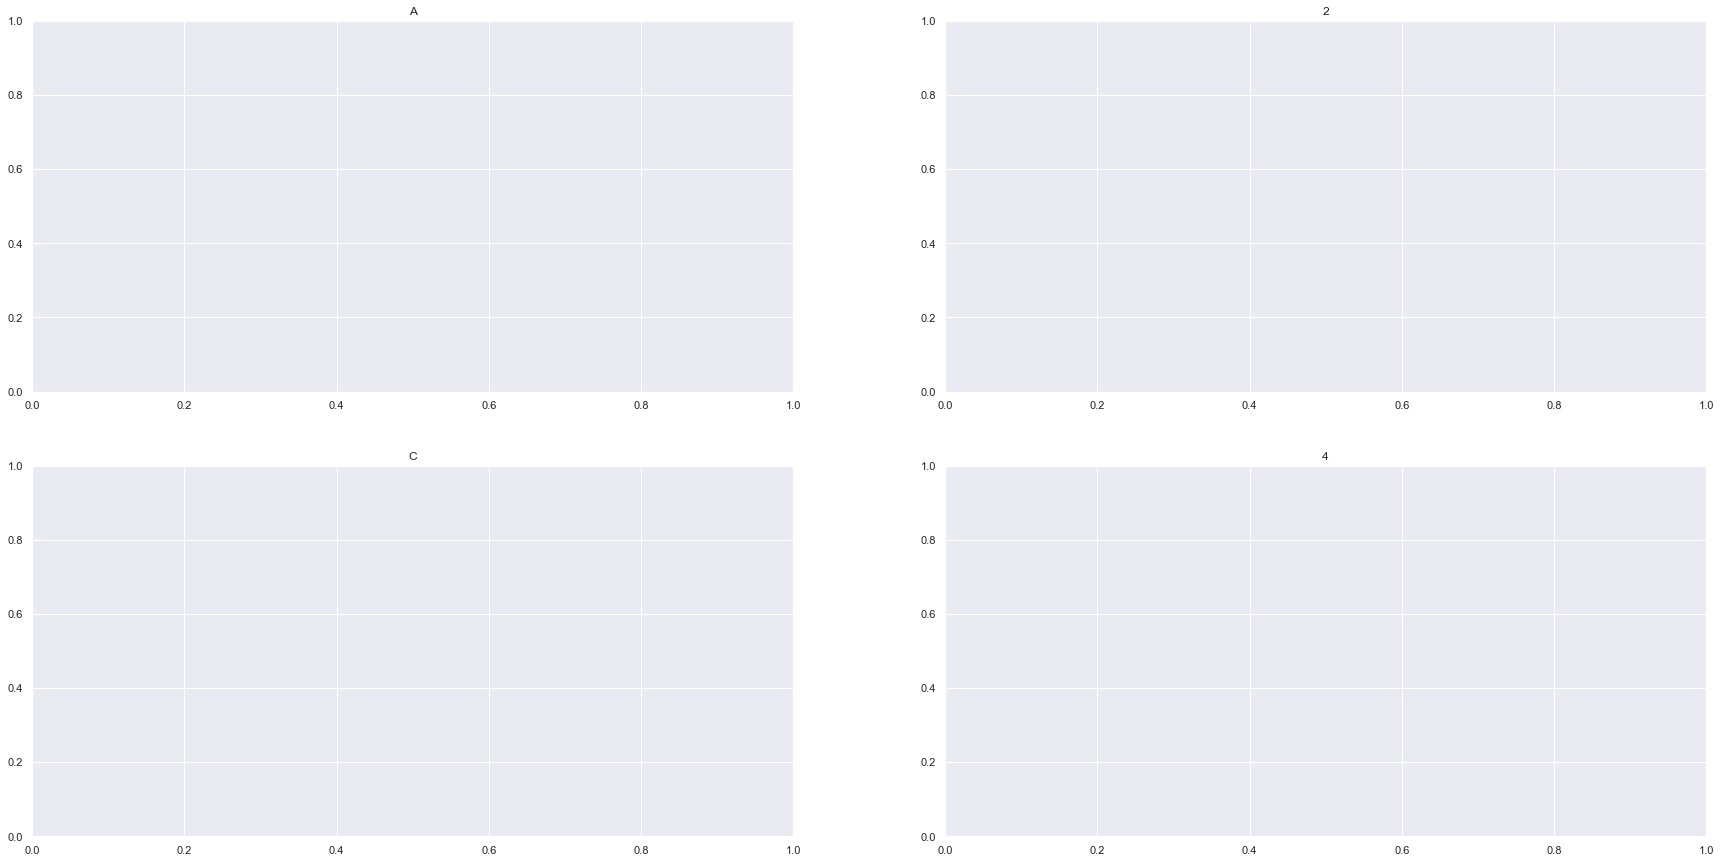

In [177]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,15))
axs_list = list(itertools.chain.from_iterable(axs))
for title, ax in zip(["A","2","C",4, 5], axs_list):
    print(title)
    ax.set_title(str(title))

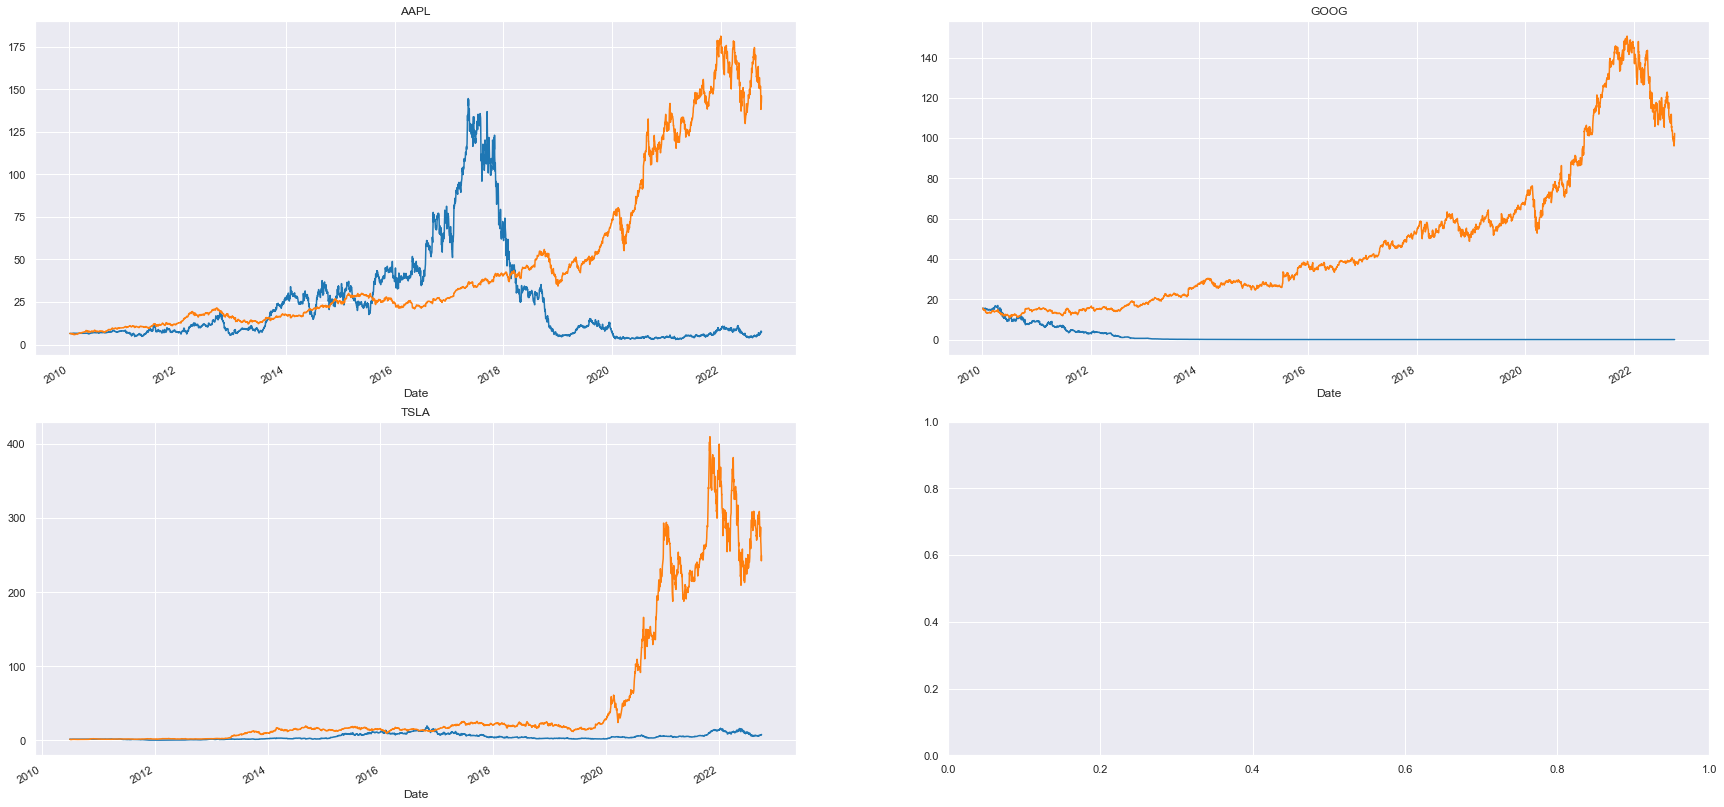

In [163]:
import itertools
import matplotlib.pyplot as plt
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,15))
axs_list = list(itertools.chain.from_iterable(axs))
for symbol, ax in zip(choice_symbols, axs_list):
    another_word_dict[symbol].Close.plot(ax=ax)
    real_dict[symbol].Close.plot(ax=ax)
    ax.set_title(symbol)

In [1]:
from sklearn.preprocessing import StandardScaler

In [3]:
def gen_fairy_tale_feature(kl_another_word):
    kl_another_word['regress_y'] = kl_another_word.Close.pct_change()
    kl_another_word['bf_yesterday_close'] = 0
    kl_another_word['yesterday_close'] = 0
    kl_another_word['yesterday_volume'] = 0
    kl_another_word['bf_yesterday_volume'] = 0
    kl_another_word['bf_yesterday_close'][2:] = kl_another_word['Close'][:-2]
    kl_another_word['bf_yesterday_volume'][2:] = kl_another_word['Volume'][:-2]
    kl_another_word['yesterday_close'][1:] = kl_another_word['Close'][:-1]
    kl_another_word['yesterday_volume'][1:] = kl_another_word['Volume'][:-1]
    kl_another_word['feature_price_change'] = kl_another_word['yesterday_close'] - kl_another_word['bf_yesterday_close']
    kl_another_word['feature_volume_change'] = kl_another_word['yesterday_volume'] - kl_another_word['bf_yesterday_volume']

    kl_another_word['feature_sign'] = np.sign(kl_another_word['feature_price_change'] * kl_another_word['feature_volume_change'])
    kl_another_word['feature_date_week'] = kl_another_word['Date_Week']

    kl_another_word['feature_volume_noise'] = kl_another_word['yesterday_volume'] * kl_another_word['bf_yesterday_volume']
    kl_another_word['feature_price_noise'] = kl_another_word['yesterday_close'] * kl_another_word['bf_yesterday_close']

    scaler = StandardScaler()
    kl_another_word['feature_price_change'] = scaler.fit_transform(np.array(kl_another_word['feature_price_change']).reshape(-1,1))    
    kl_another_word['feature_volume_change'] = scaler.fit_transform(np.array(kl_another_word['feature_volume_change']).reshape(-1,1))   
    kl_another_word['feature_volume_noise'] = scaler.fit_transform(np.array(kl_another_word['feature_volume_noise']).reshape(-1,1))   
    kl_another_word['feature_price_noise'] = scaler.fit_transform(np.array(kl_another_word['feature_price_noise']).reshape(-1,1))

    kl_fairy_tale_feature = kl_another_word.filter(regex='regress_y|feature_*')[2:]
    return kl_fairy_tale_feature


In [4]:
gen_fairy_tale_feature(another_word_dict["TSLA"])

NameError: name 'another_word_dict' is not defined

In [95]:
fairy_tale_feature = None
for symbol in another_word_dict:
    kl_another_word = another_word_dict[symbol]
    kl_feature = gen_fairy_tale_feature(kl_another_word)
    fairy_tale_feature = kl_feature if fairy_tale_feature is None else fairy_tale_feature.append(kl_feature)

In [96]:
fairy_tale_feature.shape

(9505, 7)

In [97]:
fairy_tale_feature.tail()

,regress_y,feature_price_change,feature_volume_change,feature_sign,feature_date_week,feature_volume_noise,feature_price_noise
Date,,,,,,,
2022-09-28 00:00:00-04:00,0.0363,0.9181,0.0722,1.0,2,-0.3503,0.2396
2022-09-29 00:00:00-04:00,-0.0468,0.8366,-0.1379,-1.0,3,-0.3574,0.3144
2022-09-30 00:00:00-04:00,-0.0516,-1.1361,0.4334,-1.0,4,-0.3287,0.3020
2022-10-03 00:00:00-04:00,0.0742,-1.1953,-0.1916,1.0,0,-0.2954,0.2052
2022-10-04 00:00:00-04:00,0.0938,1.6101,0.5826,1.0,1,-0.2486,0.2222


In [101]:
feature_np = fairy_tale_feature.values
train_x = feature_np[:, 1:]
train_y_regress = feature_np[:, 0]
train_y_classification = np.where(train_y_regress > 0, 1, 0)
train_x[:5], train_y_regress[:5], train_y_classification[:5]

(array([[ 0.0052,  0.9207,  1.    ,  2.    ,  0.9143, -0.4134],
        [ 0.0054, -0.4238, -1.    ,  3.    ,  1.0864, -0.4134],
        [-0.0071, -0.6391,  1.    ,  4.    ,  0.7493, -0.4134],
        [ 0.0035, -0.2517, -1.    ,  0.    ,  0.5052, -0.4134],
        [-0.0064,  0.1242, -1.    ,  1.    ,  0.4725, -0.4134]]),
 array([ 0.0018, -0.0015,  0.0013, -0.0013, -0.0017]),
 array([1, 0, 1, 0, 0]))

In [102]:
def gen_feature_from_symbol(symbol):
    kl_another_word = change_real_to_another_word(symbol)
    kl_another_word_feature_test = gen_fairy_tale_feature(kl_another_word)

    feature_np_test = kl_another_word_feature_test.values
    test_y_regress = feature_np_test[:, 0]
    test_y_classification = np.where(test_y_regress>0, 1, 0)

    test_x = feature_np_test[:, 1:]
    return test_x, test_y_regress, test_y_classification, kl_another_word_feature_test

In [104]:
test_x, test_y_regress, test_y_classification, kl_another_word_feature_test = gen_feature_from_symbol('IBM')

In [105]:
test_x

array([[-0.5686,  0.2628, -1.    ,  2.    ,  0.4431,  5.5712],
       [-0.4919, -0.4749,  1.    ,  3.    ,  0.3333,  5.4369],
       [ 0.4659,  0.0898,  1.    ,  4.    ,  0.1696,  5.4337],
       ...,
       [ 0.0126, -0.433 , -1.    ,  4.    , -0.2771, -0.3904],
       [-0.0158,  0.5598, -1.    ,  0.    , -0.2416, -0.3904],
       [-0.0152, -0.3979,  1.    ,  1.    , -0.1783, -0.3904]])

In [106]:
test_y_regress

array([-0.0106,  0.0101,  0.0074, ..., -0.0308, -0.0304,  0.0302])

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress):
    estimator.fit(train_x, train_y_regress)
    test_y_predict_regress = estimator.predict(test_x)

    plt.plot(test_y_regress.cumsum())
    plt.plot(test_y_predict_regress.cumsum())


    scores = cross_val_score(estimator, train_x, train_y_regress, cv=10, scoring="neg_mean_squared_error")
    mean_sc = np.mean(np.sqrt(-scores))
    print('RMSE: ' + str(mean_sc))

RMSE: 0.032707699767322136


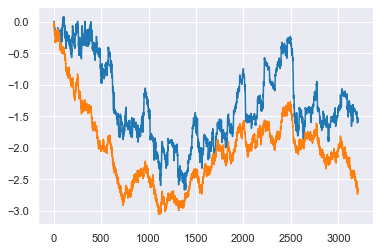

In [133]:
estimator = LinearRegression()
regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress)

RMSE: 0.03682175317893323


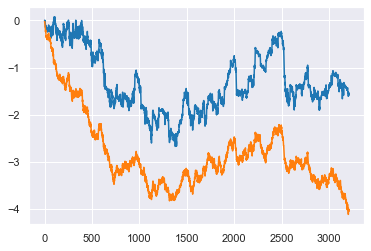

In [136]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

estimator2 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
regress_process(estimator2, train_x, train_y_regress, test_x, test_y_regress)

RMSE: 0.03175190877783378


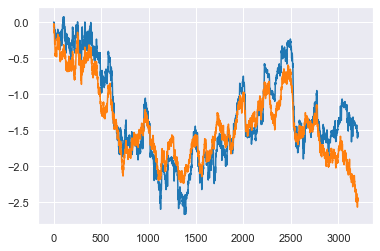

In [137]:
from sklearn.ensemble import AdaBoostRegressor

estimator3 = AdaBoostRegressor(n_estimators=100)
regress_process(estimator3, train_x, train_y_regress, test_x, test_y_regress)

RMSE: 0.030908229537907096


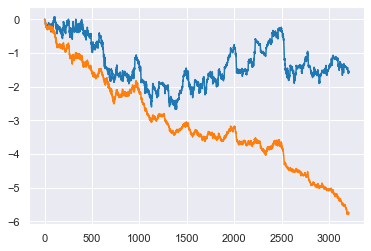

In [138]:
from sklearn.ensemble import RandomForestRegressor

estimator4 = RandomForestRegressor(n_estimators=100)
regress_process(estimator4, train_x, train_y_regress, test_x, test_y_regress)

<h2>Classification instead of regression</h2>

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [140]:
def classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification):
    estimator.fit(train_x, train_y_classification)
    test_y_predict_classification = estimator.predict(test_x)
    print("{} accuracy = {:.2f}". format(estimator.__class__.__name__, metrics.accuracy_score(test_y_classification, test_y_predict_classification)))

    scores = cross_val_score(estimator, train_x, train_y_classification, cv=10, scoring="accuracy")
    mean_sc = np.mean(scores)
    print('cross validation accuracy mean: {:.2f}'.format(mean_sc))

In [143]:
estimator = LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

LogisticRegression accuracy = 0.93
cross validation accuracy mean: 0.92


In [144]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

RandomForestClassifier accuracy = 0.92
cross validation accuracy mean: 0.91


In [145]:
def train_test_split_xy(estimator, x, y, test_size=0.5, random_state=0):
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, random_state=random_state)
    print(x.shape, y.shape)
    print(train_x.shape, train_y.shape)
    print(test_x.shape, test_y.shape)

    clf = estimator.fit(train_x, train_y)
    predictions = clf.predict(test_x)

    print("accuracy = %.2f" % (metrics.accuracy_score(test_y, predictions)))

    print("precision_score = %.2f" % (metrics.precision_score(test_y, predictions)))

    print("recall score = %.2f" % (metrics.recall_score(test_y, predictions)))
    
    return test_y, predictions

In [146]:
test_y, predicts = train_test_split_xy(estimator, train_x, train_y_classification)

(9505, 6) (9505,)
(4752, 6) (4752,)
(4753, 6) (4753,)
accuracy = 0.92
precision_score = 0.92
recall score = 0.90


In [148]:
def confusion_matrix_with_report(test_y, predictions):
    confusion_matrix = metrics.confusion_matrix(test_y, predictions)
    print("        Predicted")
    print("        |  0  |  1  |")
    print("        |-----|-----|")
    print("       0| %3d | %3d |" % (confusion_matrix[0,0], confusion_matrix[0,1]))
    print("Actual  |-----|-----|")
    print("       1| %3d | %3d |" % (confusion_matrix[1,0], confusion_matrix[1,1]))
    print("        |-----|-----|")

    print(metrics.classification_report(test_y, predictions))

confusion_matrix_with_report(test_y, predicts)

        Predicted
        |  0  |  1  |
        |-----|-----|
       0| 2196 | 175 |
Actual  |-----|-----|
       1| 228 | 2154 |
        |-----|-----|
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2371
           1       0.92      0.90      0.91      2382

    accuracy                           0.92      4753
   macro avg       0.92      0.92      0.92      4753
weighted avg       0.92      0.92      0.92      4753

